<a href="https://colab.research.google.com/github/yoshivarma/DataScience/blob/main/Randome_forest_Categorical_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#Importing all required libraries
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
import math
from scipy.stats.mstats import mode
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
import math 

# Random Forest Algorithm 
from random import seed
from random import randrange



The 1984 United States Congressional Voting Dataset

In [ ]:
#upload files
from google.colab import files
upload = files.upload()

Saving hw3_house_votes_84.csv to hw3_house_votes_84.csv


In [ ]:
#Load data
data1 = pd.read_csv('hw3_house_votes_84.csv')

In [ ]:
columns = data1.columns
columns

Index(['#handicapped-infants', 'water-project-cost-sharing',
       'adoption-of-the-budget-resolution', 'physician-fee-freeze',
       'el-salvador-adi', 'religious-groups-in-schools',
       'anti-satellite-test-ban', 'aid-to-nicaraguan-contras', 'mx-missile',
       'immigration', 'synfuels-corporation-cutback', 'education-spending',
       'superfund-right-to-sue', 'crime', 'duty-free-exports',
       'export-administration-act-south-africa', 'class'],
      dtype='object')

In [ ]:
#bootstrap dataset
def bootstrap_data(dataset, n_folds):

  #percentage of each class 
  d1= data1[data1['class']==0]
  d2= data1[data1['class']==1]
  n1= d1['class'].count()/(d1['class'].count()+d2['class'].count())
  n2= d2['class'].count()/(d1['class'].count()+d2['class'].count())

  dataset_split = list()
  dataset_copy = dataset
  fold_size = int(len(dataset) / n_folds)
  
  for i in range(n_folds):
    fold = list()
    while len(fold) < int(n1*fold_size):
      temp1 = dataset_copy[dataset_copy['class']==0].sample()
      fold.append(temp1)
      dataset_copy = dataset_copy.drop(temp1.index)


    for i in range(int(n2*fold_size)):
      temp2 = dataset_copy[dataset_copy['class']==1].sample()
      fold.append(temp2)
      dataset_copy = dataset_copy.drop(temp2.index)

    dataset_split.append(fold)
  #print("end of bootstrap")
  return dataset_split

  

In [ ]:
#defining Entropy
def Entropy(target):
  
  counts = target.value_counts()
  
  labels = np.unique(target)
  probability = 0.0

  for count in counts:
    P = 0.0
    term1 = count/np.sum(counts)
    term2 = math.log2(count/np.sum(counts))
    P = term1*term2
    probability = probability + P
  return -probability

  

In [ ]:
#define Best Split
def best_split(df, features):
  B = None
  y = -1
  
  for feature in features:
    ID = 0
    ## entropy of the parent class
    entropy = Entropy(df['class'])

    #Average entropy
    labels = np.unique(df[feature])
    if len(labels)>0:
      probability =0
      i = 0

      for v in labels:
        count = len(df[df[feature]==v])
        probability = count/len(df[feature])
        cal_df =df[df[feature]==v] 
        De = Entropy(cal_df['class']) 
        ID = (probability * De) +ID
        
      i_g = entropy - ID
      if i_g > y:
        B = feature
        y = i_g
  
  return B


In [ ]:
#class node
class Node:
  
  def __init__(self):
    self.data = 0
    self.leftChild = None
    self.middleChild = None
    self.rightChild = None

    

In [ ]:
#Growing Decision Trees
def Decision_Trees(df):
  
  N = Node()
  y = 0.0
  new_data = df.sample(n=int(math.sqrt(15)),axis='columns')
  features = list(new_data.columns[:15])
  #features = list(df.columns[:15])

  #stopping criteria 3
  if len(df) < 5:
    N.data = int(df['class'].mode().values[0])
    return N

  #stopping criteria 2
  uni = len(np.unique(df['class']))
  if uni == 1:
    N.data =  int(np.unique(df['class']))
    return N

  
  best_feature = Best_Split2(df, features)
  N.data = best_feature 
  
  for v in np.unique(df[best_feature]):

    if len(df[df[best_feature]==0]) == 0 or len(df[df[best_feature]==1])==0 or len(df[df[best_feature]==2])==0:
      N.data = int(df['class'].mode().values[0])
      return N
    #recursive function  
    N.leftChild = Decision_Trees(df[df[best_feature]==0])
    N.middleChild = Decision_Trees(df[df[best_feature]==1])
    N.rightChild = Decision_Trees(df[df[best_feature]==2])
  return N
  
    

In [ ]:
def random_forest(train, n_trees):
  trees = list()
  for i in range(n_trees):
    #print("start of decision")
    tree = Decision_Trees(train)
    #print("end of tree")
    trees.append(tree)
  
  return trees


In [ ]:
#Predicting values
def prediction(root, test, i ):
  
  if type(root.data) ==int:
    leaf = root.data
    return leaf

  else:
    value = test.at[i, root.data]
    if value==0:
      leaf = prediction(root.leftChild, test, i)

    if value==1:
      leaf = prediction(root.middleChild, test, i)

    if value==2:
      leaf = prediction(root.rightChild, test, i)
  
  return leaf

  

In [ ]:
def Majority_voting(train, test, n_trees):

  
  predicted_values_final = list()
  
  trees = random_forest(train, n_trees)

  index = test.index.values  
  for i in range(len(test)):
    predicted_values = list()
    for tree in trees:
      predicted_values.append(prediction(tree, test.iloc[[i]], index[i]))

    predicted_values_final.append(max(set(predicted_values), key = predicted_values.count))
  

  #print("predicted values", predicted_values_final)
  #print("test", test['class'])
  accuracy, precision, recall, f1_score = Metrics(predicted_values_final, test['class'])
  #print("end of majority")
  return accuracy, precision, recall, f1_score

  

In [ ]:
def Metrics(predicted_values_final, test):

  #initializing confusion matrix 
  confusion_matrix = np.matrix([[0,0],[0,0]])

  #calculating accuracy
  score = 0
  array = test.to_numpy()
  #print(len(array))
  #print(len(predicted_values_final))
  for i in range(len(predicted_values_final)):
    if predicted_values_final[i] == array[i]:
      score +=1
      if predicted_values_final[i] == 0:
        confusion_matrix[0,0] += 1
      else:
        confusion_matrix[1,1] += 1
    else:
      if predicted_values_final[i] == 0:
        confusion_matrix[1,0] += 1
      else:
        confusion_matrix[0,1] += 1
  #print("confusion", confusion_matrix)
  accuracy = score/len(predicted_values_final)

  #calculating precision of the model
  if confusion_matrix[0,0]==0 and confusion_matrix[1,0]==0:
    precision = 0
  else:
    precision = float(confusion_matrix[0,0]/ (confusion_matrix[0,0]+ confusion_matrix[1,0])) 

  #calculating recall of the model
  if confusion_matrix[0,0]==0 and confusion_matrix[0,1]==0:
    recall= 0
  else:
    recall = float(confusion_matrix[0,0]/ (confusion_matrix[0,0]+confusion_matrix[0,1]))
    #print("recall", recall)

  #F-1 Score
  f1_score = float((2 * (precision * recall)) / (precision + recall))

  return accuracy, precision, recall, f1_score
  

In [ ]:
def cross_validation(dataset, n_folds, n_trees):
  #bootstraping using n_folds
  dataset_split = bootstrap_data(dataset, n_folds)

  #initializing metrics
  avg_accuracy = list()
  avg_precision = list()
  avg_recall = list()
  avg_f1score = list()

  #iterating on the bootstraped data
  for i in range(10):

    #creating test data and training data for n_folds
    test = pd.DataFrame(np.row_stack(dataset_split[i]), columns=columns)
    count = 0
    for j in range(10):
      if i!=j:
        if count == 0:
          train = pd.DataFrame(np.row_stack(dataset_split[j]), columns=columns)
        else:
          temp_df = pd.DataFrame(np.row_stack(dataset_split[j]), columns=columns)
          train = train.append(temp_df, ignore_index=False)
        count +=1

    m = len(train)
    train1 = pd.DataFrame(train.sample(m))

    t_accuracy, t_precision, t_recall, t_f1score = Majority_voting(train, test, n_trees)

    avg_accuracy.append(t_accuracy)
    avg_precision.append(t_precision)
    avg_recall.append(t_recall)
    avg_f1score.append(t_f1score)
    #print("end of one k-fold")
  sum_accuracy = sum(avg_accuracy)/10
  sum_precicion = sum(avg_precision)/10
  sum_recall = sum(avg_recall)/10
  sum_f1score = sum(avg_f1score)/10

  return sum_accuracy, sum_precicion, sum_recall, sum_f1score
  


In [1]:
no_trees = [1,5,10,20,30,40,50]

In [ ]:
a, p, r, f = [], [], [], []
for i in no_trees:
  
  a1, p1, r1, f1 = cross_validation(df, 10, i)
  a.append(a1)
  p.append(p1)
  r.append(r1)
  f.append(f1)

Text(0, 0.5, 'Accuracy')

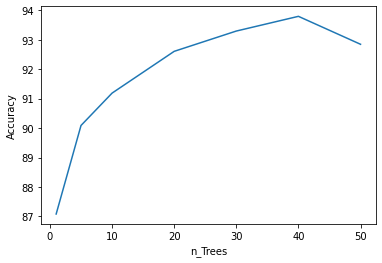

In [5]:
plt.plot(no_trees, a)
plt.xlabel('n_Trees')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Precision')

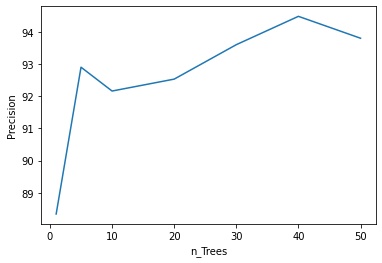

In [6]:
plt.plot(no_trees, p)
plt.xlabel('n_Trees')
plt.ylabel('Precision')

Text(0, 0.5, 'Recall')

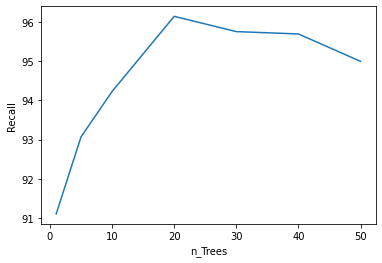

In [7]:
plt.plot(no_trees, r)
plt.xlabel('n_Trees')
plt.ylabel('Recall')


Text(0, 0.5, 'F-1_score')

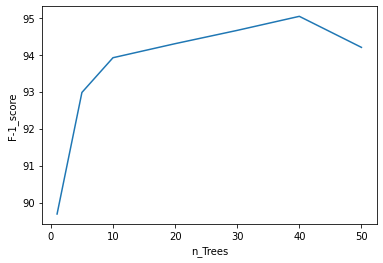

In [8]:
plt.plot(no_trees, f)
plt.xlabel('n_Trees')
plt.ylabel('F-1_score')


In [ ]:
def Best_Split2(dataset, features):

  y=0
  B = None

  for feature in features:

    prob_final = 0

    labels = np.unique(dataset[feature])
    
    if len(labels)>0 and len(dataset[feature])>0:
      for v in labels:
        prob_sum = 0 
        c = dataset[dataset[feature]==v]
        for x in np.unique(c['class']):
          count = len(c[c['class']==x])
          probability = pow( count/len(c), 2)
          prob_sum = probability +prob_sum
          
        prob_final = ((len(c)/ len(dataset[feature])) * (1-prob_sum) ) + prob_final
      
      
      if prob_final >= y:
          B = feature
          y = prob_final
  
  return B


In [ ]:
a, p, r, f = [], [], [], []
for i in no_trees:
  
  a1, p1, r1, f1 = cross_validation(df, 10, i)
  a.append(a1)
  p.append(p1)
  r.append(r1)
  f.append(f1)

Text(0, 0.5, 'Accuracy')

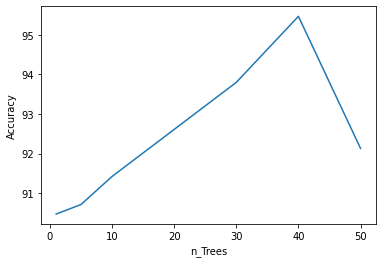

In [10]:
plt.plot(no_trees, a)
plt.xlabel('n_Trees')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Precision')

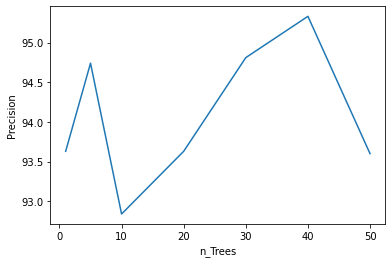

In [11]:
plt.plot(no_trees, p)
plt.xlabel('n_Trees')
plt.ylabel('Precision')

Text(0, 0.5, 'Recall')

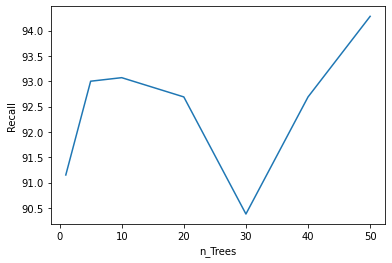

In [12]:
plt.plot(no_trees, r)
plt.xlabel('n_Trees')
plt.ylabel('Recall')


Text(0, 0.5, 'F-1_score')

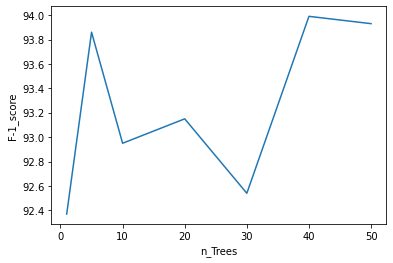

In [13]:
plt.plot(no_trees, f)
plt.xlabel('n_Trees')
plt.ylabel('F-1_score')
